In [96]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch 
import os
import glob
from matplotlib import pyplot as plt
import os
import torch
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from datasets import example_datasets, to_numpy
from torch_models import  MixtureOfTruncNormModel, torch_bpr_uncurried, deterministic_bpr
from torch_perturb.torch_pert_topk import PerturbedBrokenTopK
from distributions import QuantizedNormal



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
seed=360
# tracts/distributions
S=7

# total timepoints
T= 500
K=5

dist_S = [QuantizedNormal(10, 0.3),
          QuantizedNormal(20, 0.3),
          QuantizedNormal(30, 0.3),
          QuantizedNormal(40, 0.3),
          QuantizedNormal(50, 0.3),
          QuantizedNormal(60, 0.3),
          QuantizedNormal(100, 0.3)]

train_y_TS = np.zeros((T, S))
for s, dist in enumerate(dist_S):
    random_state = np.random.RandomState(10000 * seed + s*123456)
    train_y_TS[:, s] = dist.rvs(size=T, random_state=random_state)

(array([0.04813665, 0.        , 0.        , 0.04534472, 0.00279193,
        0.        , 0.00163665, 0.0465    , 0.        , 0.        ,
        0.04813665, 0.        , 0.        , 0.04572981, 0.00240683,
        0.        , 0.00192547, 0.04621118, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04813665]),
 array([  9.        ,  11.96774194,  14.93548387,  17.90322581,
         20.87096774,  23.83870968,  26.80645161,  29.77419355,
         32.74193548,  35.70967742,  38.67741935,  41.64516129,
         44.61290323,  47.58064516,  50.5483871 ,  53.51612903,
         56.48387097,  59.4516129 ,  62.41935484,  65.38709677,
         68.35483871,  71.32258065,  74.29032258,  77.25806452,
         80.22580645,  83.19354839,  86.16129032,  89.12903226,
         92.09677419,  95.06451613,  98.03225806, 101.        ]),
 <BarContainer object of 31 artists>)

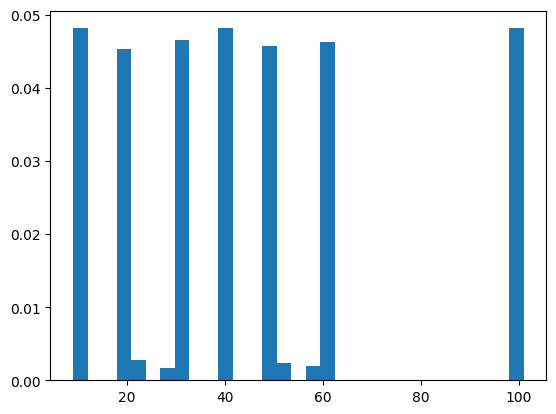

In [98]:
plt.hist(train_y_TS[:, :].flatten(), bins=31, density=True)

In [122]:
model = MixtureOfTruncNormModel(num_components=2, S=S)

In [123]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
M_score_func, M_action = 100, 100
perturbed_top_K_func = PerturbedBrokenTopK(k=K, sigma=0.05)
bpr_weight, nll_weight = 30,0
from torch_training import train_epoch
threshold=1

In [124]:
means = [20,70]
scales = [5, 5]
softinv_means = torch.tensor(means) + torch.log(-torch.expm1(-torch.tensor(means)))
softinv_scales = torch.tensor(scales) - 0.2 + torch.log1p(-torch.expm1(-torch.tensor(scales)+0.2))
all_mix_weights = np.random.dirichlet([0.5]*2, (20,S))
mix_weights = torch.log(1e-13 + torch.tensor(all_mix_weights[10]))
mix_weights = torch.log(1e-13 + torch.tensor(np.array([[1,0], [1,0], [1,0], [1,0], [1,0], [0,1], [0,1]])).view(-1))
model.update_params(torch.cat([softinv_means, softinv_scales, mix_weights.view(-1)]))

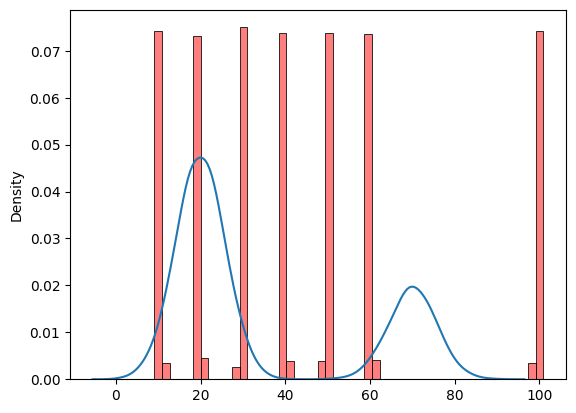

In [125]:
model.plot_learned(data=train_y_TS)

In [126]:
for epoch in range(100):
    _, _, _, model = train_epoch(model, optimizer, K, threshold, T, M_score_func, M_action, train_y_TS, perturbed_top_K_func, bpr_weight, nll_weight, update=True)

det bpr: 0.8862004643635182
Pert bpr: 0.8927128448763112
nll: 8.170468453897604
Loss: -26.781385346289337
det bpr: 0.8929883961525925
Pert bpr: 0.8930541162289545
nll: 8.175330224078795
Loss: -26.791623486868634
det bpr: 0.8906185725587177
Pert bpr: 0.8927517093931654
nll: 8.068484709552395
Loss: -26.782551281794962
det bpr: 0.8894636200531543
Pert bpr: 0.8927955319948094
nll: 7.9820040092725515
Loss: -26.783865959844285
det bpr: 0.8982940891036253
Pert bpr: 0.8929155545223658
nll: 7.949930818638927
Loss: -26.787466635670974
det bpr: 0.8920327265222175
Pert bpr: 0.8926905195924831
nll: 7.906929146830693
Loss: -26.780715587774495
det bpr: 0.8917708602620309
Pert bpr: 0.8927636372425618
nll: 7.8488389145794235
Loss: -26.782909117276855
det bpr: 0.8982544230755356
Pert bpr: 0.8930129854766228
nll: 7.80989733410114
Loss: -26.790389564298682
det bpr: 0.8935468543045042
Pert bpr: 0.8929708636565297
nll: 7.76410331094898
Loss: -26.78912590969589
det bpr: 0.8928657221432819
Pert bpr: 0.8929096

In [75]:
train_epoch(model, optimizer, K, threshold, T, M_score_func, M_action, train_y_TS, perturbed_top_K_func, bpr_weight, nll_weight, update=False)

det bpr: 0.853615304750196
Pert bpr: 0.8571493479194888
nll: 3.847520192798354
Loss: 3.847520192798354


(tensor(3.8475, dtype=torch.float64),
 tensor(0.8536, dtype=torch.float64),
 tensor(3.8475, dtype=torch.float64),
 MixtureOfTruncNormModel())

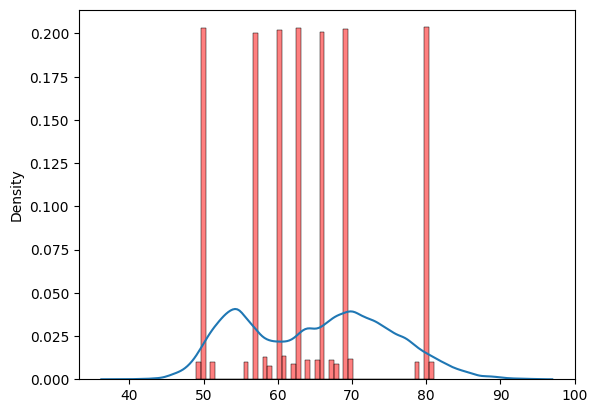

det bpr: 1.0
Pert bpr: 0.9559373863580805
nll: 3.1896442349595175
Loss: 3.1896442349595175


(tensor(3.1896, dtype=torch.float64),
 tensor(1., dtype=torch.float64),
 tensor(3.1896, dtype=torch.float64),
 MixtureOfTruncNormModel())